# Proje 1: CIFAR-10 Sınıflandırmada Ham Pikseller ve HOG Özelliklerinin Karşılaştırılması

**Amaç:** Bu notebook'un amacı, bir görüntü sınıflandırma problemi olan CIFAR-10 üzerinde iki farklı yaklaşımı karşılaştırmaktır:

1.  **Baseline (Temel) Yaklaşım:** Görüntülerin "ham piksel" değerlerini düzleştirip doğrudan bir Lineer SVM sınıflandırıcıya vermek.
2.  **Özellik Mühendisliği Yaklaşımı:** Görüntülerden elle tasarlanmış (hand-crafted) özellikler olan **HOG (Histogram of Oriented Gradients)** özelliklerini çıkarıp bu özellikleri Lineer SVM sınıflandırıcıya vermek.

Bu çalışma, CNN'lerin (Evrişimli Sinir Ağları) neden bu kadar devrimsel olduğunu anlamak için önemli bir temel sağlar. CNN'ler, HOG gibi özellikleri manuel olarak tasarlamak yerine, bu özellikleri doğrudan veriden *öğrenirler*.

# Gerekli Kütüphanelerin Yüklenmesi

In [3]:
#veri seti yükleme ve işleme
import numpy as np
from tensorflow.keras.datasets import cifar10

#Feature Extraction(özellik çıkarımı) ve normalizasyon
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler

#Model(SVM) ve değerlendirme
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Veri görselleştirme
import matplotlib.pyplot as plt
#İşlem sürelerini kıyaslamak için
import time



# Veri Yükleme ve Hazırlama

In [5]:
# HIZLI DENEME İÇİN VERİ SETİNİ KÜÇÜLTME
# Eğitim için 50.000 yerine 5.000 örnek
# Test için 10.000 yerine 1.000 örnek alalım.

(x_train_color, y_train), (x_test_color, y_test) = cifar10.load_data()
num_train_samples = 5000
num_test_samples = 1000

x_train_color = x_train_color[:num_train_samples]
y_train = y_train[:num_train_samples]

x_test_color = x_test_color[:num_test_samples]
y_test = y_test[:num_test_samples]

# --- Sizin kodunuz buradan devam ediyor ---
y_train = y_train.ravel()
y_test = y_test.ravel()

#Sınıflarımız(bunları tahmin etmeye çalışacağız)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Eğitim verisi şekli : {x_train_color.shape}")
print(f"Test verisi şekli : {x_test_color.shape}")
print(f"Eğitim etiketleri şekli: {y_train.shape}")

Eğitim verisi şekli : (5000, 32, 32, 3)
Test verisi şekli : (1000, 32, 32, 3)
Eğitim etiketleri şekli: (5000,)


# Veriyi Görselleştirme

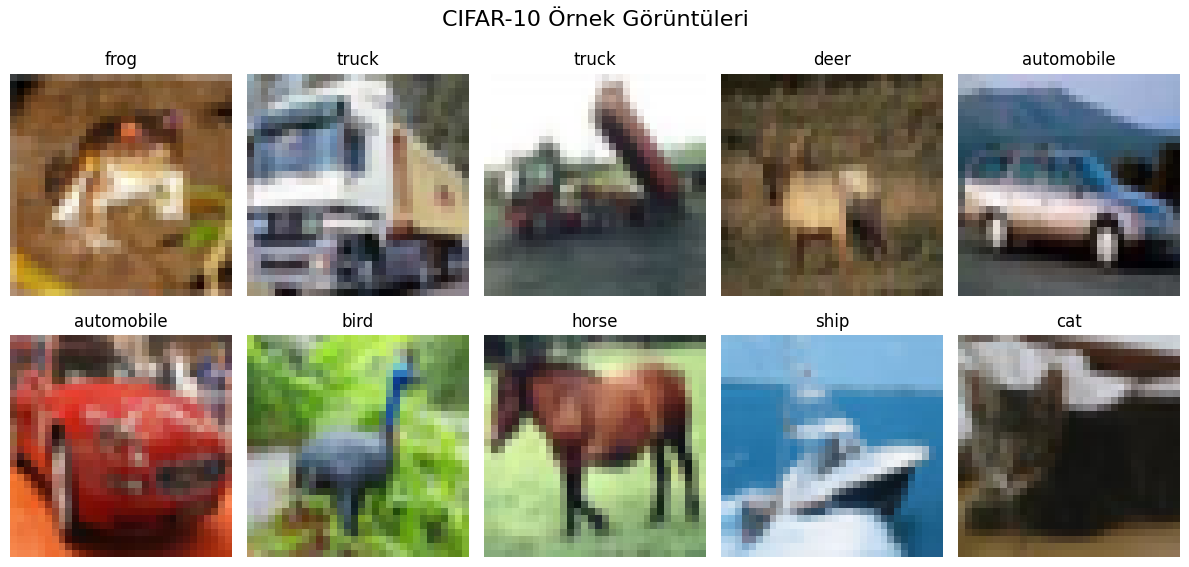

In [6]:

plt.figure(figsize=(12, 6))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_train_color[i])
  plt.title(class_names[y_train[i]])
  plt.axis('off')

plt.suptitle('CIFAR-10 Örnek Görüntüleri', fontsize=16)
plt.tight_layout()
plt.show()

# Veriyi Gri Tonlamaya (Grayscale) Çevirme

Görüntüler gri tonlamaya çevriliyor...
Çevirme tamamlandı.
Eğitim verisi şekli (Gri): (5000, 32, 32)
Test verisi şekli (Gri): (1000, 32, 32)


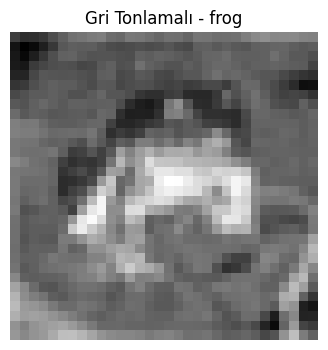

In [7]:
print("Görüntüler gri tonlamaya çevriliyor...")
# skimage.color.rgb2gray kullanarak gri tonlamaya çevirelim
x_train_gray = np.array([rgb2gray(img) for img in x_train_color])
x_test_gray = np.array([rgb2gray(img) for img in x_test_color])
print("Çevirme tamamlandı.")

print(f"Eğitim verisi şekli (Gri): {x_train_gray.shape}")
print(f"Test verisi şekli (Gri): {x_test_gray.shape}")

# Bir örneğe bakalım
plt.figure(figsize=(4, 4))
plt.imshow(x_train_gray[0], cmap='gray')
plt.title(f"Gri Tonlamalı - {class_names[y_train[0]]}")
plt.axis('off')
plt.show()

# Yaklaşım 1: Ham Pikseller (Baseline) + SVM
##Bu yaklaşımda 32x32 boyutundaki gri tonlamalı görüntüleri 1024 boyutlu tek bir vektöre düzleştireceğiz(flatten)
##Ardından bu vektörleri normalize edip SVM modelini eğiteceğiz

In [8]:
# 1. Görüntüyü tek boyutlu vektöre çevirme(flatten)
# (50000,32,32) -> (50000,1024)

nsamples,nx,ny = x_train_gray.shape
x_train_flat = x_train_gray.reshape((nsamples , nx * ny))

ntestsamples, nx, ny = x_test_gray.shape
x_test_flat = x_test_gray.reshape((ntestsamples, nx * ny))

print(f"Düzleştirilmiş eğitim verisi şekli: {x_train_flat.shape}")

# 2. Veriyi Normalize Etme (StandardScaler)
# SVM gibi modeller, özelliklerin ortalamasını 0 ve varyansının 1 olduğu
# normalize edilmiş verilere daha duyarlıdır

scaler_raw = StandardScaler()
x_train_raw_norm = scaler_raw.fit_transform(x_train_flat)
x_test_raw_norm = scaler_raw.transform(x_test_flat)

# 3. Lineer SVM Modelini Eğitme
print("Yaklaşım-1 (Ham Pikseller) SVM eğitimi başlıyor...")
start_time = time.time()


# dual=False, n_samples > n_features olduğunda genellikle daha hızlıdır.
# max_iter'i yakınsama için artırabiliriz.
svm_raw = LinearSVC(max_iter=2000, dual=False, random_state=42, verbose=1)
svm_raw.fit(x_train_raw_norm, y_train)
end_time = time.time()
print(f"Eğitim {end_time - start_time:.2f} saniye sürdü.")


# 4. Değerlendirme
y_pred_raw = svm_raw.predict(x_test_raw_norm)
acc_raw = accuracy_score(y_test, y_pred_raw)

print(f"\n--- YAKLAŞIM 1 (HAM PİSELLER) SONUÇLARI ---")
print(f"Doğruluk (Accuracy): {acc_raw * 100:.2f}%")

Düzleştirilmiş eğitim verisi şekli: (5000, 1024)
Yaklaşım-1 (Ham Pikseller) SVM eğitimi başlıyor...
[LibLinear]Eğitim 104.19 saniye sürdü.

--- YAKLAŞIM 1 (HAM PİSELLER) SONUÇLARI ---
Doğruluk (Accuracy): 16.80%


## Yaklaşım 2: HOG (Histogram of Oriented Gradients) + SVM

**HOG nedir?** Görüntüdeki kenarların (gradients) yönelimlerinin ve dağılımının histogramını çıkaran bir özellik tanımlayıcıdır. Görüntüyü küçük hücrelere böler, her hücre için gradyan yönelimlerinin bir histogramını oluşturur ve bu histogramları normalize ederek bir özellik vektörü elde eder. Bu, piksellerden daha "anlamlı" bir bilgidir.

Şimdi aynı gri tonlamalı görüntülerden HOG özelliklerini çıkarıp SVM modelini eğiteceğiz.

In [9]:
# 1. HOG Özelliklerini Çıkarma
# Parametreleri seçmek önemlidir. CS231n'dekine benzer ayarlar kullanalım.
# pixels_per_cell=(8, 8) -> Görüntüyü 8x8'lik hücrelere böl.

print("HOG özellikleri çıkarılıyor (Bu işlem biraz zaman alabilir)...")
start_time = time.time()

hog_features_train = []
for img in x_train_gray:
    fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
             cells_per_block=(2, 2), block_norm='L2-Hys',
             visualize=False)
    hog_features_train.append(fd)
x_train_hog = np.array(hog_features_train)

hog_features_test = []
for img in x_test_gray:
    fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
             cells_per_block=(2, 2), block_norm='L2-Hys',
             visualize=False)
    hog_features_test.append(fd)
x_test_hog = np.array(hog_features_test)

end_time = time.time()
print(f"HOG çıkarma işlemi {end_time - start_time:.2f} saniye sürdü.")
print(f"HOG özellik vektör boyutu (Eğitim): {x_train_hog.shape}")
print(f"HOG özellik vektör boyutu (Test): {x_test_hog.shape}")


# 2. HOG Özelliklerini Normalize Etme
scaler_hog = StandardScaler()
x_train_hog_norm = scaler_hog.fit_transform(x_train_hog)
x_test_hog_norm = scaler_hog.transform(x_test_hog)

# 3. Lineer SVM Modelini Eğitme (HOG Özellikleri ile)
print("\nYaklaşım 2 (HOG Özellikleri) SVM eğitimi başlıyor...")
start_time = time.time()

svm_hog = LinearSVC(max_iter=2000, dual=False, random_state=42, verbose=1)
svm_hog.fit(x_train_hog_norm, y_train)

end_time = time.time()
print(f"Eğitim {end_time - start_time:.2f} saniye sürdü.")

# 4. Değerlendirme
y_pred_hog = svm_hog.predict(x_test_hog_norm)
acc_hog = accuracy_score(y_test, y_pred_hog)

print(f"\n--- YAKLAŞIM 2 (HOG ÖZELLİKLERİ) SONUÇLARI ---")
print(f"Doğruluk (Accuracy): {acc_hog * 100:.2f}%")

HOG özellikleri çıkarılıyor (Bu işlem biraz zaman alabilir)...
HOG çıkarma işlemi 2.79 saniye sürdü.
HOG özellik vektör boyutu (Eğitim): (5000, 324)
HOG özellik vektör boyutu (Test): (1000, 324)

Yaklaşım 2 (HOG Özellikleri) SVM eğitimi başlıyor...
[LibLinear]Eğitim 7.27 saniye sürdü.

--- YAKLAŞIM 2 (HOG ÖZELLİKLERİ) SONUÇLARI ---
Doğruluk (Accuracy): 46.70%


# Sonuç ve Karşılaştırma

Bu çalışmada, CIFAR-10 verisetini sınıflandırmak için iki farklı özellik gösterimini karşılaştırdık:

| Yöntem | Test Doğruluğu |
| :--- | :---: |
| Yaklaşım 1: Ham Pikseller (Gri) + SVM | **16.80%** |
| Yaklaşım 2: HOG Özellikleri + SVM | **46.70%** |


**Çıkarım:**
Görüldüğü gibi, HOG özellikleri ham piksel değerlerine göre **önemli ölçüde daha iyi** bir sınıflandırma performansı sağlamıştır. Bunun nedeni, HOG'un görüntüdeki *anlamsal* bilgiyi (kenarlar, şekiller, dokular) yakalayabilmesidir. Ham pikseller ise aydınlatma, küçük kaymalar ve gürültü gibi alakasız değişikliklere karşı çok hassastır.

**CNN'lere Bağlantı:**
Bu proje, CNN'lerin neden bu kadar güçlü olduğunu mükemmel bir şekilde göstermektedir. Biz HOG gibi özellikleri "elle tasarlamak" ve hangi parametrelerin (pixels_per_cell vb.) en iyi sonucu vereceğini denemek zorunda kaldık.

**CNN'ler ise, bu özellik çıkarma işlemini *otomatik* olarak yapar.** İlk katmanları basit kenarları ve renkleri (HOG'un yaptığı gibi), daha derin katmanları ise bu basit özellikleri birleştirerek daha karmaşık şekilleri (göz, tekerlek, kedi kulağı vb.) öğrenir. Bu "öğrenilebilir özellik hiyerarşisi", CNN'lerin görüntü tanımada devrim yapmasının temel nedenidir.